In [1]:
from fears.population import Population
from fears.experiment import Experiment
from scipy.stats.qmc import LatinHypercube, scale
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fears.utils import stats, plotter, pharm
import scipy.stats as spstats
import os

np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

options = {
    'mut_rate':10**-9,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*3,
    'death_model':'pharmacodynamic',
    'n_timestep':350,
    'plot':False,
    'k_abs':4.61,
    'k_elim':0.63,
    'max_dose':40,
    'regimen_length':10*24,
    'dose_schedule':8,
    'curve_type':'pulsed',
    'n_sims':1,
    'death_rate':0.01
    # 'timestep_scale':0.5
}

p = Population(**options)

In [2]:
n_dimensions = 4 # cmax, kelim, carrying capacity, mutation rate
n_samples = 300

sampler = LatinHypercube(d=n_dimensions)
sample = sampler.random(n=n_samples)
sample_raw = sample

min_cmax = 30
max_cmax = 52

min_kelim = -np.log(0.5)/2
max_kelim = -np.log(0.5)/0.5

min_mut_rate = -10
max_mut_rate = -7

min_carrying_cap = 7
max_carrying_cap = 10

lbounds = [min_cmax,min_kelim,min_carrying_cap,min_mut_rate]
ubounds = [max_cmax,max_kelim,max_carrying_cap,max_mut_rate]

sample = scale(sample,lbounds,ubounds)

sample[:,2] = 10**sample[:,2]
sample[:,3] = 10**sample[:,3]

In [3]:
min_kelim = -np.log(0.5)/2
max_kelim = -np.log(0.5)/0.5

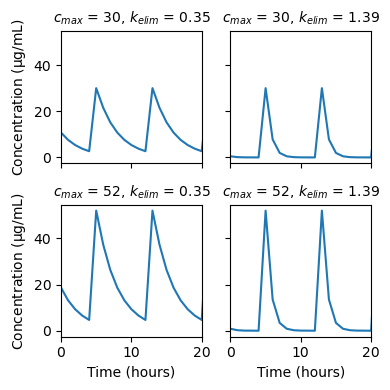

In [4]:
fig,ax_list = plt.subplots(ncols=2,nrows=2,figsize=(4,4),sharex=True,sharey=True)

ax_list = ax_list.flatten()

indx = 0
for cmax in [30,52]:
    for kelim in [min_kelim,max_kelim]:

        ax = ax_list[indx]

        p.max_dose = cmax
        p.k_elim = kelim

        p.reset_drug_conc_curve()
        p.drug_curve = p.max_dose*(p.drug_curve/np.max(p.drug_curve))

        ax.plot(p.drug_curve)

        ax.set_title('$c_{max}$ = ' + str(cmax) + ', $k_{elim}$ = ' + str(round(kelim,2)),fontsize=10)

        ax.set_xlim(100,120)

        indx += 1

ax.set_xticks([100,110,120])
ax.set_xticklabels([0,10,20])

ax_list[-1].set_xlabel('Time (hours)')
ax_list[-2].set_xlabel('Time (hours)')

ax_list[0].set_ylabel('Concentration ($\mathrm{\mu}$g/mL)')
ax_list[2].set_ylabel('Concentration ($\mathrm{\mu}$g/mL)')

fig.tight_layout()

fig.savefig('../figures/example_drug_curves.pdf',bbox_inches='tight')

In [5]:
res = np.zeros(n_samples)
n_sims = 100

for i in range(n_samples):
    
    p.mut_rate = sample[i,3]
    p.carrying_cap = sample[i,2]
    p.k_elim = sample[i,1]
    p.max_dose = sample[i,0]

    p.reset_drug_conc_curve()

    p.drug_curve = p.max_dose*(p.drug_curve/np.max(p.drug_curve))
    
    for j in range(n_sims):
        counts,et = p.simulate()
        if np.sum(counts,axis=1)[-1] <= 1:
            res[i] += 1
            


/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_58630/3301395089.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


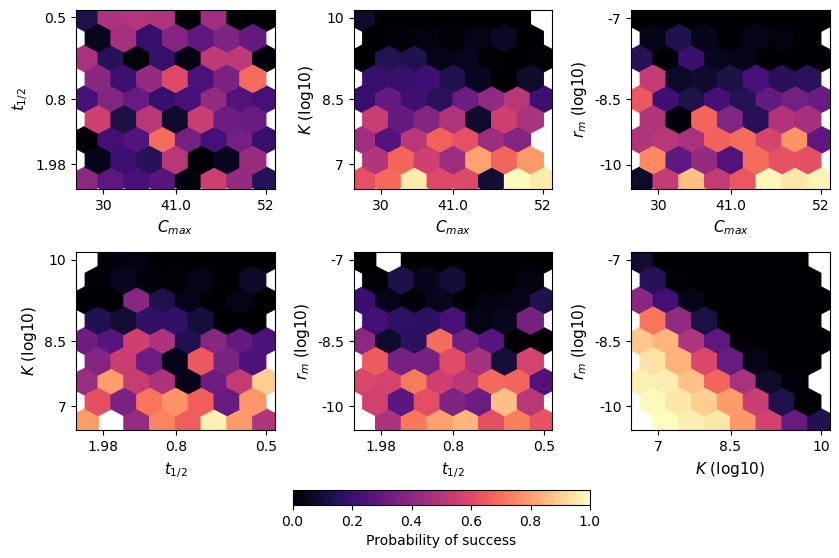

In [6]:
fig,ax_list = plt.subplots(ncols=3,nrows=2,figsize=(8.5,5))

# cmax, kelim, carrying capacity, mutation rate

cmap = 'magma'

ax = ax_list[0,0]

# ax.scatter(sample_raw[:,0],sample_raw[:,1],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,1],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$t_{1/2}$',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
thalf = np.array([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
thalf = np.round(-np.log(0.5)/thalf,2)
# ax.set_yticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_yticklabels(thalf)

ax = ax_list[0,1]

# ax.scatter(sample_raw[:,0],sample_raw[:,2],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,2],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$K$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax = ax_list[0,2]

# ax.scatter(sample_raw[:,0],sample_raw[:,3],c=res/n_sims)
ax.hexbin(sample_raw[:,0],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$C_{max}$',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax = ax_list[1,0]

# ax.scatter(sample_raw[:,1],sample_raw[:,2],c=res/n_sims)
ax.hexbin(sample_raw[:,1],sample_raw[:,2],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$t_{1/2}$',fontsize=11)
ax.set_ylabel('$K$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax = ax_list[1,1]

# ax.scatter(sample_raw[:,1],sample_raw[:,3],c=res/n_sims)
ax.hexbin(sample_raw[:,1],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$t_{1/2}$',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax = ax_list[1,2]

# ax.scatter(sample_raw[:,2],sample_raw[:,3],c=res/n_sims)
hb = ax.hexbin(sample_raw[:,2],sample_raw[:,3],C=res/n_sims,gridsize=7,vmin=0,vmax=1,cmap=cmap)

ax.set_xlabel('$K$ (log10)',fontsize=11)
ax.set_ylabel('$r_{m}$ (log10)',fontsize=11)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax.set_yticks([0.1,0.5,1])
ax.set_yticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

cax = fig.add_axes([0.35,-0.02,0.35,0.03])

cb = fig.colorbar(hb,orientation='horizontal',cax=cax)
cb.set_label('Probability of success')

# ax_list[0,0].annotate('A',xy=(-0.2,1.1),xycoords='axes fraction',fontsize=12)
fig.tight_layout()

fig.savefig('../figures/pharmacokinetics_joint_distribution.pdf',bbox_inches='tight')

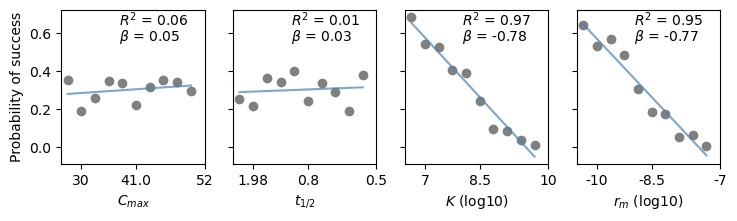

In [7]:
# plot marginal distributions for each parameter

fig,ax_list = plt.subplots(ncols=4,nrows=1,figsize=(8.5,2),sharex=False,sharey=True)

# generate bins

bins = np.linspace(0,0.9,10)

cmax_marg = []
kelim_marg = []
carry_marg = []
mut_marg = []

rate = res/n_sims

for bin in bins:
    indx = (sample_raw[:,0] > bin) & (sample_raw[:,0] <= bin + 0.1)
    cmax_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,1] > bin) & (sample_raw[:,1] <= bin + 0.1)
    kelim_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,2] > bin) & (sample_raw[:,2] <= bin + 0.1)
    carry_marg.append(np.mean(rate[indx]))

    indx = (sample_raw[:,3] > bin) & (sample_raw[:,3] <= bin + 0.1)
    mut_marg.append(np.mean(rate[indx]))

ax = ax_list[0]
ax.scatter(bins,cmax_marg,color='gray')

# compute regression
regres = spstats.linregress(bins,cmax_marg)
ax.plot(bins,regres.intercept + regres.slope*bins,color='steelblue',alpha=0.7)

# annotate R^2 and p-value
ax.annotate('$R^2$ = ' + str(round(regres.rvalue**2,2)),xy=(0.4,0.9),xycoords='axes fraction',fontsize=10)
# ax.annotate('$p = $' + str(round(regres.pvalue,2)),xy=(0.1,0.7),xycoords='axes fraction',fontsize=10)
ax.annotate(r'$\beta$ = ' + str(round(regres.slope,2)),xy=(0.4,0.8),xycoords='axes fraction',fontsize=10)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_cmax,2),np.round((min_cmax+max_cmax)/2,2),np.round(max_cmax,2)])

ax.set_xlabel('$C_{max}$')

ax = ax_list[1]

ax.scatter(bins,kelim_marg,color='gray')

regres = spstats.linregress(bins,kelim_marg)
ax.plot(bins,regres.intercept + regres.slope*bins,color='steelblue',alpha=0.7)

ax.annotate('$R^2$ = ' + str(round(regres.rvalue**2,2)),xy=(0.4,0.9),xycoords='axes fraction',fontsize=10)
ax.annotate(r'$\beta$ = ' + str(round(regres.slope,2)),xy=(0.4,0.8),xycoords='axes fraction',fontsize=10)

ax.set_xticks([0.1,0.5,1])
# ax.set_xticklabels([np.round(min_kelim,2),np.round((min_kelim+max_kelim)/2,2),np.round(max_kelim,2)])
ax.set_xticklabels(thalf)

ax.set_xlabel('$t_{1/2}$')

ax = ax_list[2]

ax.scatter(bins,carry_marg,color='gray')

regres = spstats.linregress(bins,carry_marg)
ax.plot(bins,regres.intercept + regres.slope*bins,color='steelblue',alpha=0.7)

ax.annotate('$R^2$ = ' + str(round(regres.rvalue**2,2)),xy=(0.4,0.9),xycoords='axes fraction',fontsize=10)
# ax.annotate('$p < 10^{' + str(int(np.round(np.log10(regres.pvalue)))) + '}$',xy=(0.5,0.7),xycoords='axes fraction',fontsize=10)
ax.annotate(r'$\beta$ = ' + str(round(regres.slope,2)),xy=(0.4,0.8),xycoords='axes fraction',fontsize=10)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_carrying_cap,2),np.round((min_carrying_cap+max_carrying_cap)/2,2),np.round(max_carrying_cap,2)])

ax.set_xlabel('$K$ (log10)')  

ax = ax_list[3]

ax.scatter(bins,mut_marg,color='gray')

regres = spstats.linregress(bins,mut_marg)
ax.plot(bins,regres.intercept + regres.slope*bins,color='steelblue',alpha=0.7)

ax.annotate('$R^2$ = ' + str(round(regres.rvalue**2,2)),xy=(0.4,0.9),xycoords='axes fraction',fontsize=10)
ax.annotate(r'$\beta$ = ' + str(round(regres.slope,2)),xy=(0.4,0.8),xycoords='axes fraction',fontsize=10)

ax.set_xticks([0.1,0.5,1])
ax.set_xticklabels([np.round(min_mut_rate,2),np.round((min_mut_rate+max_mut_rate)/2,2),np.round(max_mut_rate,2)])

ax.set_xlabel('$r_{m}$ (log10)')

ax_list[0].set_ylabel('Probability of success')

# ax_list[0].annotate('B',xy=(-0.3,1.1),xycoords='axes fraction',fontsize=12);

fig.savefig('../figures/pharmacokinetics_marginal_distributions.pdf',bbox_inches='tight')

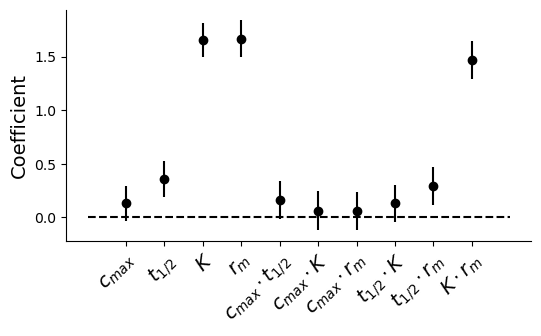

In [8]:
import statsmodels.api as sm

# fit a linear model to all four parameters
# cmax, kelim, carrying capacity, mutation ra

xl = ['$c_{max}$','$t_{1/2}$','$K$','$r_{m}$','$c_{max} \cdot t_{1/2}$','$c_{max} \cdot K$','$c_{max} \cdot r_{m}$','$t_{1/2} \cdot K$','$t_{1/2} \cdot r_{m}$','$K \cdot r_{m}$']

data = {'x1':sample_raw[:,0],'x2':sample_raw[:,1],'x3':sample_raw[:,2],'x4':sample_raw[:,3],'y':res/n_sims}

formula = 'y ~ x1 + x2 + x3 + x4'

model = sm.formula.ols(formula=formula,data=data).fit()

# print(model.summary())

# print(model.pvalues)

# test interaction terms

formula = 'y ~ x1 + x2 + x3 + x4 + x1*x2 + x1*x3 + x1*x4 + x2*x3 + x2*x4 + x3*x4'

data = {'x1':sample_raw[:,0],'x2':sample_raw[:,1],'x3':sample_raw[:,2],'x4':sample_raw[:,3],'y':res/n_sims}

model = sm.formula.ols(formula=formula,data=data).fit()

conf_int = model.conf_int(alpha=0.05)[1:]
coeffs = model.params[1:]

fig,ax = plt.subplots(figsize=(6,3))

ax.errorbar(np.arange(1,len(model.params)),np.abs(model.params)[1:],yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],fmt='o',color='black')

ax.set_xticks(np.arange(1,len(model.params)))
ax.set_xticklabels(xl,rotation=45,ha='right',fontsize=14,rotation_mode='anchor')

ax.set_ylabel('Coefficient',fontsize=14)

ax.plot([0,len(model.params)],[0,0],'--',color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../figures/pharmacokinetics_interaction_terms.png',bbox_inches='tight',dpi=500)

# print(model.pvalues)

In [9]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type
import statsmodels
import pandas as pd

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = 'default'
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

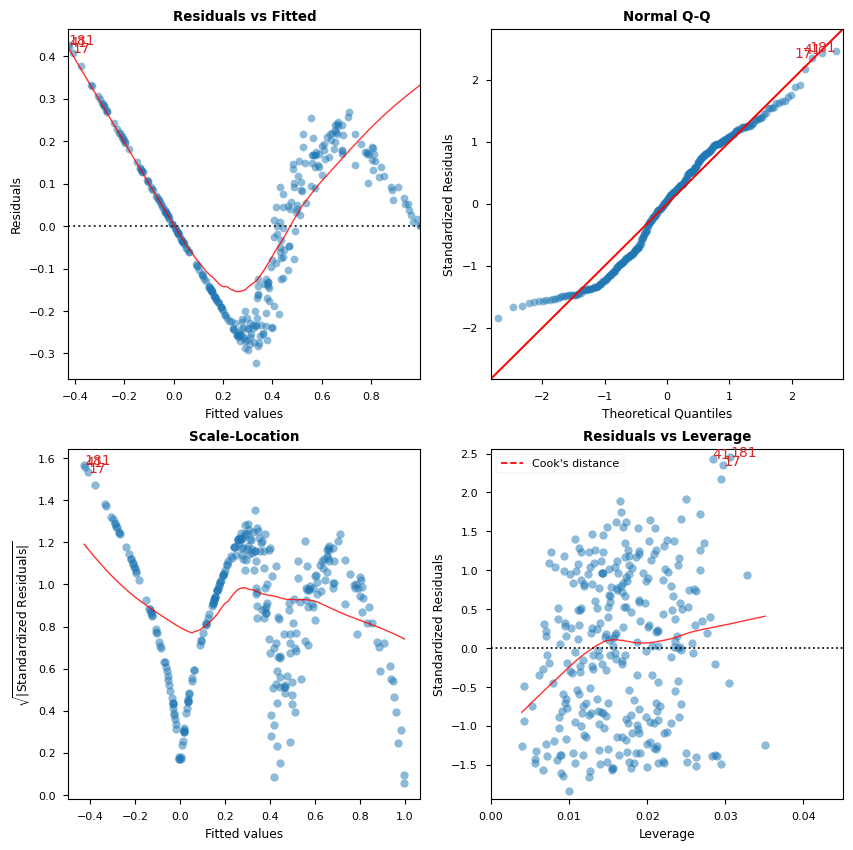

(    Features  VIF Factor
 2         x2        1.00
 1         x1        1.00
 4         x4        1.00
 3         x3        1.01
 0  Intercept       14.08,
 <Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>,
         <Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>],
        [<Axes: title={'center': 'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>,
         <Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>]],
       dtype=object))

In [10]:
data = {'x1':sample_raw[:,0],'x2':sample_raw[:,1],'x3':sample_raw[:,2],'x4':sample_raw[:,3],'y':res/n_sims}

formula = 'y ~ x1 + x2 + x3 + x4'

model = sm.formula.ols(formula=formula,data=data).fit()


cls = LinearRegDiagnostic(model)

cls()

In [11]:
# use generalized linear model

formula = 'y ~ x1 + x2 + x3 + x4'

model = sm.formula.glm(formula=formula,data=data).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  300
Model:                            GLM   Df Residuals:                      295
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                        0.031082
Method:                          IRLS   Log-Likelihood:                 97.508
Date:                Tue, 11 Jun 2024   Deviance:                       9.1692
Time:                        13:45:59   Pearson chi2:                     9.17
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9643
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1201      0.038     29.322      0.0

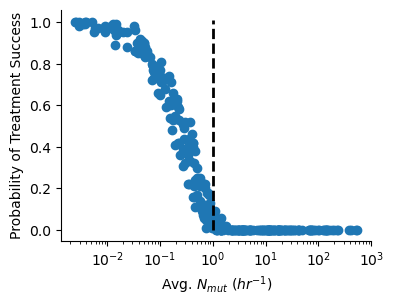

In [12]:
indx = (res/n_sims > 0.3) & (res/n_sims < 0.7)

fig,ax = plt.subplots(figsize=(4,3))

ax.plot(sample[:,2]*sample[:,3],res/n_sims,'o')

ax.plot([1,1],[0,1.01],'--',color='k',linewidth=2)

ax.set_xscale('log')

ax.set_xlabel('Avg. $N_{mut}$ ($hr^{-1}$)')

ax.set_ylabel('Probability of Treatment Success')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../figures/mutation_supply.pdf',bbox_inches='tight')

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_58630/3263692968.py:14: RuntimeWarning: invalid value encountered in log10
  return 1/(1+np.exp(k*(np.log10(n_mut)-np.log10(ic50))))


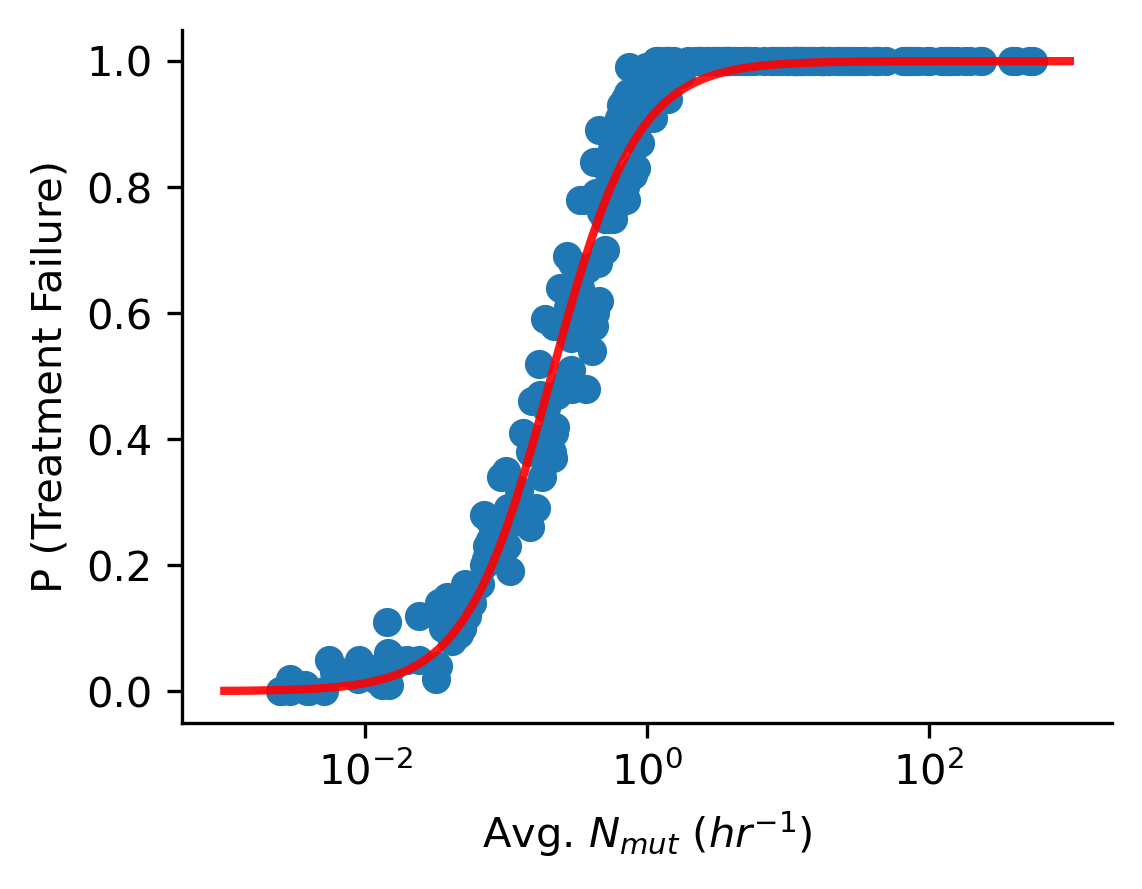

In [52]:
# fit poisson cdf to data
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

mut_supply = np.array(sample[:,2]*sample[:,3])
# mut_supply = mut_supply-np.min(mut_supply)

p_fail = 1-res/n_sims

from scipy.optimize import curve_fit
from scipy.stats import poisson

def p_fail_logistic(n_mut,k,ic50):
    return 1/(1+np.exp(k*(np.log10(n_mut)-np.log10(ic50))))

popt,pcov = curve_fit(p_fail_logistic,mut_supply,p_fail,p0=[1,1])

fig,ax = plt.subplots(figsize=(4,3))

ax.plot(mut_supply,p_fail,'o')

x = np.logspace(-3,3,100)
ax.plot(x,p_fail_logistic(x,*popt),linewidth=2,color='red',alpha=0.9)

ax.set_xscale('log')

ax.set_ylabel('P (Treatment Failure)')
ax.set_xlabel('Avg. $N_{mut}$ ($hr^{-1}$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [50]:
np.log10(popt[1])

-0.6787874681938189

[6. 1. 2.]


AttributeError: PathCollection.set() got an unexpected keyword argument 'arrow_alpha_list'

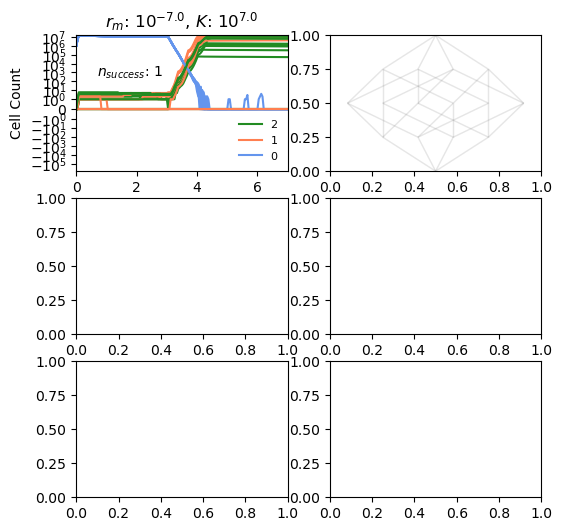

In [13]:
# trajectory analysis

np.random.seed(2024)

arrowprops = dict(arrowstyle='->', color='black', lw=2,mutation_scale=10,shrinkA=5,shrinkB=7)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

params = [(10**-7,10**7),(10**-8,10**8),(10**-10,10**9)]

fig,ax_list = plt.subplots(ncols=2,nrows=3,figsize=(6,6))

time = np.arange(p.n_timestep)/24

for i,param in enumerate(params):

    p.mut_rate = param[0]
    p.carrying_cap = param[1]

    p.k_elim = -np.log(0.5)/1.5
    p.max_dose = 40

    p.reset_drug_conc_curve()

    p.drug_curve = p.max_dose*(p.drug_curve/np.max(p.drug_curve))

    ax = ax_list[i,0]

    traj_list = []
    
    n_success = 0

    # for sim_num in range(2):
    for sim_num in range(10):

        counts,et = p.simulate()
        trajectory = [0]
        for t in range(len(counts[:,0])):
            pop = counts[t,:]
            max_gen = np.argmax(pop)
            if max_gen != trajectory[-1]:
                trajectory.append(max_gen)

        if len(trajectory) > 1:
            traj_list.append(trajectory)

        if np.sum(counts,axis=1)[-1] < 1:
            n_success += 1

        ax.plot(time,counts[:,0],color='cornflowerblue',label='0')
        ax.plot(time,counts[:,1],color='coral',label='1')
        ax.plot(time,counts[:,2],color='forestgreen',label='2')

    ax.set_xlim(0,7)

    ax.set_yscale('symlog',linthresh=1)

    ax.set_title('$r_{m}$: $10^{%s}$, $K$: $10^{%s}$' % (np.log10(param[0]),np.log10(param[1])))

    ax.annotate('$n_{success}$: %s' % n_success,xy=(0.1,0.7),xycoords='axes fraction')

    handles,labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    ax.legend(unique_handles,unique_labels,frameon=False,loc='lower right',fontsize=8)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cell Count')

    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  

    traj_list_count = np.zeros((len(traj_list_unique)))

    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    print(traj_list_count)

    alpha_list = traj_list_count/6

    traj_list_count = 5*(np.array(traj_list_count)/np.sum(traj_list_count))

    traj_list_count[traj_list_count < 0.5] = 0.5

    ax = ax_list[i,1]

    cby = 0.25 - 0.45*i

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.max(p.drug_curve),
                            colorbar=True,arrow_alpha_list=alpha_list,**landscape_options,
                            ax=ax,cbloc = [0.62,cby,0.3,0.5])

# move rows 2 and 3 down
    
for i in range(2):
    for j in range(2):
        pos = ax_list[i+1,j].get_position()
        ax_list[i+1,j].set_position([pos.x0,pos.y0-0.1*(i+1),pos.width,pos.height])



fig.savefig('../figures/pharmacokinetics_trajectories.pdf',bbox_inches='tight')

# fig.tight_layout()

In [ ]:
alpha_list

array([0.16666667])